In [1]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
##### For preprocessing #####
import os
import re
import email
import codecs
##### For performance evaluation #####
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [2]:
#### uploaded the files in the google drive and located the path

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

data_path = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/data/'
labels_path = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/labels.txt'
stop_data_path = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/stop_words.txt'


Mounted at /content/drive


In [3]:
#### verified the content of the data directory 0 - 127

if os.path.exists(data_path):
    folders = os.listdir(data_path)
    sorted_folders = sorted(folders, key=lambda x: int(x))
    print("Files in the data directory:")
    for folder in sorted_folders:
        print(folder)
else:
    print(f"Directory {data_path} not found.")

Files in the data directory:
000
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
082
083
084
085
086
087
088
089
090
091
092
093
094
095
096
097
098
099
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


In [4]:
#### initializes the email dataframe

emails_df = pd.DataFrame(columns=['folder', 'file', 'message', 'classification'])

In [5]:
#### inititialize label dataframe
#### vectorized by turning ham = 0 and spam = 1

labels_df = pd.read_csv(labels_path, sep=' ', header=None, names=['classification', 'folder_file'])
labels_df['classification'] = labels_df['classification'].apply(lambda x: 0 if x == 'ham' else 1)
labels_df['folder'] = labels_df['folder_file'].apply(lambda x: x.replace("../data/", ""))

In [6]:
emails_df1 = labels_df[['classification', 'folder']]
emails_df1.head()

,classification,folder
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004


In [7]:
#### extracting original messages from the parsed email
def get_messages(parsed_email):
    message = ""
    if parsed_email.is_multipart():
        for part in parsed_email.walk():
            if part.get_content_type() == "text/plain":
                message = part.get_payload(decode=True).decode(part.get_content_charset() or 'utf-8')
                break
    else:
        message = parsed_email.get_payload(decode=True).decode(parsed_email.get_content_charset() or 'utf-8')
    return message.strip()

In [8]:
import chardet

def get_email_charset(email_path):
    """Detect the character encoding of the email content."""
    detector = chardet.UniversalDetector()
    with open(email_path, 'rb') as e_mail:
        for line in e_mail:
            detector.feed(line)
            if detector.done:  # Check if the detection is complete
                break
    detector.close()
    return detector.result['encoding']


In [9]:
emails_df_without_stopwords = pd.DataFrame(columns=['folder', 'file', 'message', 'classification'])

folders = os.listdir(data_path)
folders.sort(key=lambda x: int(x))
for folder in folders:
    files = os.listdir(os.path.join(data_path, folder))
    files.sort()
    for file in files:
        try:
            with open(os.path.join(data_path, folder, file), "r", encoding="ISO-8859-1") as e_mail:
                read_email = e_mail.read()
                parsed_email = email.message_from_string(read_email)
                message = get_messages(parsed_email)

                ## obtaining category based on df
                category_label = emails_df1[emails_df1["folder"] == f"{folder}/{file}"]["classification"].values[0]

                ## emails_df = pd.DataFrame(columns=['folder', 'file', 'message', 'classification'])

                ## concatenate the data to emails_df
                emails_df_without_stopwords = pd.concat([emails_df_without_stopwords, pd.DataFrame([[folder, file, message, category_label]], columns=["folder", "file", "message", "classification"])], ignore_index=True)

        except Exception:
            continue

emails_df_without_stopwords.head()


,folder,file,message,classification
0,000,000,The mailing list I queried about a few weeks a...,0
1,000,001,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY...,1
2,000,002,Academic Qualifications available from prestig...,1
3,000,003,Greetings all. This is to verify your subscri...,0
4,000,004,try chauncey may conferred the luscious not co...,1


In [10]:
emails_df_without_stopwords.head(-20)

,folder,file,message,classification
0,000,000,The mailing list I queried about a few weeks a...,0
1,000,001,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY...,1
2,000,002,Academic Qualifications available from prestig...,1
3,000,003,Greetings all. This is to verify your subscri...,0
4,000,004,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
35274,125,294,"Hi,\n \nL \nC \nV \nX \nV \nA \nP \ne \nI \nI ...",1
35275,125,295,,1
35276,125,297,i can show you how you can spruce up your educ...,1
35277,125,298,Hi\n \nX\nV\nV\nL\nP\nA\nC\na\nA\nI\ne\nr\nm\n...,1


In [16]:
#### preprocessed_emails.csv are exported inside a folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

not_preprocessed_folder = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/not_preprocessed_data'
if not os.path.exists(not_preprocessed_folder):
    os.makedirs(not_preprocessed_folder)



## save to csv
emails_df_without_stopwords.to_csv(os.path.join(not_preprocessed_folder, 'not_preprocessed_emails.csv'), index=False, escapechar='\\')

print(f"Preprocessed emails path: {not_preprocessed_folder}/not_preprocessed_emails.csv")


Mounted at /content/drive
Preprocessed emails path: /content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/not_preprocessed_data/not_preprocessed_emails.csv


# Subjecting the dataset (without removing the stop words) to the different tests

In [17]:
#### improrting pre-processed data
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

not_preprocessed_path = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/not_preprocessed_data/not_preprocessed_emails.csv'

Mounted at /content/drive


In [19]:
#### loading the data in a dataframe
no_data = pd.read_csv(not_preprocessed_path)
no_data.head()

,folder,file,message,classification
0,0,0,The mailing list I queried about a few weeks a...,0
1,0,1,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY...,1
2,0,2,Academic Qualifications available from prestig...,1
3,0,3,Greetings all. This is to verify your subscri...,0
4,0,4,try chauncey may conferred the luscious not co...,1


In [20]:
#### splitting the train and the test set
no_train_df = no_data[no_data['folder'] <= 70]
no_test_df = no_data[no_data['folder'] > 70]

no_train_ham_df = no_train_df[no_train_df['classification'] == 0]
no_train_spam_df = no_train_df[no_train_df['classification'] == 1]

In [21]:
#### checking the test size of the train and test
print("Train dataset size:", len(no_train_df))
print("Test dataset size:", len(no_test_df))
print("Train ham dataset size:", len(no_train_ham_df))
print("Train spam dataset size:", len(no_train_spam_df))


Train dataset size: 19910
Test dataset size: 15389
Train ham dataset size: 7450
Train spam dataset size: 12460


In [22]:
no_data

,folder,file,message,classification
0,0,0,The mailing list I queried about a few weeks a...,0
1,0,1,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY...,1
2,0,2,Academic Qualifications available from prestig...,1
3,0,3,Greetings all. This is to verify your subscri...,0
4,0,4,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
35294,126,16,bla bla bla\neee\ne\n\n\n\n\n\n\n\nrererreerer...,1
35295,126,18,The OIL sector is going crazy. This is our wee...,1
35296,126,19,http://vdtobj.docscan.info/?23759301\n\nSuffer...,1
35297,126,20,U N I V E R S I T Y D I P L O M A S\n\nDo you...,1


In [23]:
no_data = no_data.dropna()
no_data

,folder,file,message,classification
0,0,0,The mailing list I queried about a few weeks a...,0
1,0,1,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY...,1
2,0,2,Academic Qualifications available from prestig...,1
3,0,3,Greetings all. This is to verify your subscri...,0
4,0,4,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
35294,126,16,bla bla bla\neee\ne\n\n\n\n\n\n\n\nrererreerer...,1
35295,126,18,The OIL sector is going crazy. This is our wee...,1
35296,126,19,http://vdtobj.docscan.info/?23759301\n\nSuffer...,1
35297,126,20,U N I V E R S I T Y D I P L O M A S\n\nDo you...,1


In [24]:
no_train_ham_df

,folder,file,message,classification
0,0,0,The mailing list I queried about a few weeks a...,0
3,0,3,Greetings all. This is to verify your subscri...,0
5,0,5,"It's quiet. Too quiet. Well, how about a str...",0
6,0,6,It's working here. I have departed almost tot...,0
10,0,10,Greetings all. This is a mass acknowledgement...,0
...,...,...,...,...
19883,70,270,Here is an equation that generate all prime nu...,0
19884,70,271,Here is an equation that generate all prime nu...,0
19899,70,288,Dear DMDX Users:\n\nI would like guidance in g...,0
19903,70,293,"Hi,\n\nI built up a handyboard and most of it ...",0


In [25]:
no_train_spam_df

,folder,file,message,classification
1,0,1,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY...,1
2,0,2,Academic Qualifications available from prestig...,1
4,0,4,try chauncey may conferred the luscious not co...,1
7,0,7,From NBC Today Show:\n\nIt's the look everyone...,1
8,0,8,The OIL sector is going crazy. This is our wee...,1
...,...,...,...,...
19904,70,294,%TXT_ADD,1
19905,70,295,スピード！簡単！無料！\n今どきの出会いの仕方ですね。\nhttp://get-high.b...,1
19906,70,296,Special Offer\nAdobe Video Collection\nAdobe P...,1
19907,70,297,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01 T...",1


In [26]:
no_train_df

,folder,file,message,classification
0,0,0,The mailing list I queried about a few weeks a...,0
1,0,1,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY...,1
2,0,2,Academic Qualifications available from prestig...,1
3,0,3,Greetings all. This is to verify your subscri...,0
4,0,4,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
19905,70,295,スピード！簡単！無料！\n今どきの出会いの仕方ですね。\nhttp://get-high.b...,1
19906,70,296,Special Offer\nAdobe Video Collection\nAdobe P...,1
19907,70,297,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01 T...",1
19908,70,298,I have mounted the IS1U60 infrared demodulator...,0


In [27]:
no_test_df

,folder,file,message,classification
19910,71,0,Where we can hesitantly derive perverse satisf...,1
19911,71,1,There are several things you can use to perfor...,0
19912,71,2,Best offer of the month:\n\nViggra - $76.95\nC...,1
19913,71,3,"De i ar Home O h wne n r , \n \nYour cr v ed ...",1
19914,71,4,Special Offer\nAdobe Video Collection\nAdobe P...,1
...,...,...,...,...
35294,126,16,bla bla bla\neee\ne\n\n\n\n\n\n\n\nrererreerer...,1
35295,126,18,The OIL sector is going crazy. This is our wee...,1
35296,126,19,http://vdtobj.docscan.info/?23759301\n\nSuffer...,1
35297,126,20,U N I V E R S I T Y D I P L O M A S\n\nDo you...,1


In [28]:
#### Counting top 10000 words from the training dataset
word_counts = {}

for index, row in no_train_df.iterrows():
    for word in str(row['message']).split():
        word_counts[word] = word_counts.get(word, 0) + 1

## getting 10000 words & corresponding frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10000]
top_10000_words = dict(sorted_words)
top_10000_words_list = list(top_10000_words.keys())

feature_matrix_spam = np.zeros((len(no_train_spam_df), 10000))

for index in range(len(no_train_spam_df)):
    for word in str(no_train_spam_df.iloc[index]['message']).split():
        if word in top_10000_words:
            feature_matrix_spam[index][top_10000_words_list.index(word)] = 1

In [29]:
#### creating word counts dictionary and get the top 10,000 words
from collections import Counter

word_counts = Counter(word for message in no_train_df['message'] for word in str(message).split())
top_10000_words = dict(word_counts.most_common(10000))
top_10000_words_list = list(top_10000_words.keys())
top_10000_words


{'the': 102563,
 'to': 63681,
 'and': 52098,
 '>': 52095,
 'a': 49652,
 'of': 47061,
 'I': 32805,
 'in': 29602,
 'is': 29076,
 'for': 24090,
 'you': 21010,
 'that': 19920,
 'on': 17705,
 'with': 16639,
 'be': 15122,
 'it': 14650,
 'have': 13392,
 'this': 13225,
 '-': 12673,
 'are': 11970,
 'your': 11169,
 'The': 11151,
 'from': 10800,
 'as': 10664,
 'or': 10227,
 'at': 9975,
 'will': 9641,
 'not': 9641,
 'A': 9629,
 'by': 9168,
 '<td': 9082,
 'can': 8004,
 'but': 7993,
 'an': 7356,
 'was': 6318,
 'we': 6285,
 'has': 6228,
 'my': 5772,
 'if': 5541,
 '>>': 5348,
 'all': 5300,
 'would': 5258,
 'our': 4992,
 'one': 4978,
 'i': 4811,
 'about': 4745,
 'any': 4686,
 'You': 4622,
 'get': 4578,
 'This': 4454,
 'some': 4403,
 '|': 4280,
 'up': 4233,
 'do': 4110,
 'like': 4084,
 '<br>': 4012,
 'use': 3990,
 'which': 3918,
 'out': 3881,
 '</tr>': 3808,
 'more': 3740,
 'there': 3636,
 'they': 3597,
 'what': 3589,
 'We': 3544,
 '<tr>': 3498,
 'L': 3490,
 'so': 3472,
 'Adobe': 3465,
 'been': 3459,
 '

In [30]:
## sparse matrix
messages_split = no_train_df['message'].apply(lambda x: str(x).split())
max_words = max(messages_split.apply(len))
max_columns = 127

df_words = pd.DataFrame(np.full((len(messages_split), max_columns), None))
for i, words in enumerate(messages_split):
    for j, word in enumerate(words[:max_columns]):
        df_words.iloc[i, j] = word

df_words.head()


,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,The,mailing,list,I,queried,about,a,few,weeks,ago,...,Catholics,on,the,net,is,that,they,do,not,know
1,LUXURY,WATCHES,-,BUY,YOUR,OWN,ROLEX,FOR,ONLY,$219!,...,None,None,None,None,None,None,None,None,None,None
2,Academic,Qualifications,available,from,prestigious,NON-ACC,REDITED,uni,versities.,Do,...,None,None,None,None,None,None,None,None,None,None
3,Greetings,all.,This,is,to,verify,your,subscription,to,the,...,None,None,None,None,None,None,None,None,None,None
4,try,chauncey,may,conferred,the,luscious,not,continued,a,tonsillitis,...,None,None,None,None,None,None,None,None,None,None


In [31]:
#### initializes feature matrix for spam
featurematrix_spam = np.zeros((len(no_train_spam_df), len(top_10000_words)), dtype=int)
top_10000_words_list = list(top_10000_words.keys())

for index in range(len(no_train_spam_df)):
    words = str(no_train_spam_df.iloc[index]['message']).split()
    for word in words:
        if word in top_10000_words:

            featurematrix_spam[index][top_10000_words_list.index(word)] = 1


featurematrix_spam


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [33]:
#### initializing feature matrix for the ham
featurematrix_ham = np.zeros((len(no_train_ham_df), len(top_10000_words)), dtype=int)
top_10000_words_list = list(top_10000_words.keys())

for index in range(len(no_train_ham_df)):
    words = str(no_train_ham_df.iloc[index]['message']).split()
    for word in words:
        if word in top_10000_words:
            featurematrix_ham[index][top_10000_words_list.index(word)] = 1

featurematrix_ham


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [34]:
#### Calculate prior probabilities for spam and ham
prior_spam = len(no_train_spam_df) / len(no_train_df)
prior_ham = len(no_train_ham_df) / len(no_train_df)

print(f"Prior probability of spam: {prior_spam}")
print(f"Prior probability of ham: {prior_ham}")


Prior probability of spam: 0.6258161727774988
Prior probability of ham: 0.37418382722250126


In [35]:
#### function for laplace smoothing
def laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes):
    p_word_given_spam = np.zeros(len(top_10000_words))
    p_word_given_ham = np.zeros(len(top_10000_words))

    spam_word_count = np.sum(feature_matrix_spam, axis=0)
    ham_word_count = np.sum(feature_matrix_ham, axis=0)

    total_spam_words = np.sum(spam_word_count)
    total_ham_words = np.sum(ham_word_count)


    for i in range(len(top_10000_words)):
        p_word_given_spam[i] = (spam_word_count[i] + laplace_smoothing_val) / (total_spam_words + laplace_smoothing_val * num_classes)
        p_word_given_ham[i] = (ham_word_count[i] + laplace_smoothing_val) / (total_ham_words + laplace_smoothing_val * num_classes)

    return p_word_given_spam, p_word_given_ham

## initializing laplace smoothing parameter and number of classes
laplace_smoothing_val = 1
num_classes = 2
spam_word_probs, ham_word_probs = laplace_smoothing(featurematrix_spam, featurematrix_ham, laplace_smoothing_val, num_classes)


In [36]:
#### print likelihood of being spam or ham

print(f"Likelihood of a word being in a spam email: {spam_word_probs}")
print(f"Likelihood of a word being in a ham email: {ham_word_probs}")


Likelihood of a word being in a spam email: [6.96215484e-03 7.24301209e-03 7.54080545e-03 ... 4.23402889e-06
 4.23402889e-06 3.52835741e-05]
Likelihood of a word being in a ham email: [1.02863276e-02 9.72670474e-03 8.48940166e-03 ... 3.06642646e-05
 2.45314117e-05 7.66606616e-06]


In [37]:
## table form of the likelihood

likelihood_df = pd.DataFrame({
    'Word': top_10000_words_list,
    'P(Word|Spam)': spam_word_probs,
    'P(Word|Ham)': ham_word_probs
})

likelihood_df.head(20)


,Word,P(Word|Spam),P(Word|Ham)
0,the,0.006962,0.010286
1,to,0.007243,0.009727
2,and,0.007541,0.008489
3,>,0.000210,0.004255
4,a,0.007096,0.009031
5,of,0.005957,0.008091
6,I,0.002593,0.008335
7,in,0.006738,0.007008
8,is,0.005082,0.007579
9,for,0.004681,0.007215


In [38]:
#### classifying the emails using the computed probabilities
def classify_email(email, spam_word_probs, ham_word_probs, p_spam, p_ham):
    log_p_spam = 0
    log_p_ham = 0

    words = str(email).split()

    for word in words:
        if word in top_10000_words:
            log_p_spam += np.log(spam_word_probs[top_10000_words_list.index(word)])
            log_p_ham += np.log(ham_word_probs[top_10000_words_list.index(word)])

    log_p_spam += np.log(p_spam)
    log_p_ham += np.log(p_ham)

    return 1 if log_p_spam > log_p_ham else 0

In [43]:
# prompt: table form the df in classifying email

no_test_df['predicted_classification'] = no_test_df['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))

classification_results_df = pd.DataFrame({
    'Message': no_test_df['message'],
    'Actual Classification': no_test_df['classification'],
    'Predicted Classification': no_test_df['predicted_classification']
})

classification_results_df.head(20)


<ipython-input-43-90081e54f90e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_test_df['predicted_classification'] = no_test_df['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))


,Message,Actual Classification,Predicted Classification
19910,Where we can hesitantly derive perverse satisf...,1,1
19911,There are several things you can use to perfor...,0,0
19912,Best offer of the month:\n\nViggra - $76.95\nC...,1,1
19913,"De i ar Home O h wne n r , \n \nYour cr v ed ...",1,1
19914,Special Offer\nAdobe Video Collection\nAdobe P...,1,1
19915,This is a multi-part message in MIME format.\n...,1,1
19916,%TXT_ADD,1,1
19917,The Mistersporty Incorporation\nRambrantplein ...,1,1
19918,"ED Choice, your best choice for ED drugs\n\nVi...",1,1
19919,"I've changed the DMDX listserv subject filter,...",0,0


In [44]:
#### classify the test emails
no_test_df.loc[:,'predicted'] = no_test_df['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))
correct_test = (no_test_df['classification'] == no_test_df['predicted']).sum()

print(f"Correctly classified {correct_test} out of {len(no_test_df)} test emails ({correct_test / len(no_test_df) * 100}%)")

Correctly classified 13769 out of 15389 test emails (89.47300019494445%)


<ipython-input-44-14914959a31b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_test_df.loc[:,'predicted'] = no_test_df['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))


In [45]:
#### correct_test in a dataframe
correct_df = no_test_df[no_test_df['classification'] == no_test_df['predicted']]
print("DataFrame of Correctly Classified Emails")
display(correct_df)


DataFrame of Correctly Classified Emails


,folder,file,message,classification,predicted_classification,predicted
19910,71,0,Where we can hesitantly derive perverse satisf...,1,1,1
19911,71,1,There are several things you can use to perfor...,0,0,0
19912,71,2,Best offer of the month:\n\nViggra - $76.95\nC...,1,1,1
19913,71,3,"De i ar Home O h wne n r , \n \nYour cr v ed ...",1,1,1
19914,71,4,Special Offer\nAdobe Video Collection\nAdobe P...,1,1,1
...,...,...,...,...,...,...
35293,126,15,Genuine College Degree in 2 Weeks! \n\nHave yo...,1,1,1
35294,126,16,bla bla bla\neee\ne\n\n\n\n\n\n\n\nrererreerer...,1,1,1
35295,126,18,The OIL sector is going crazy. This is our wee...,1,1,1
35296,126,19,http://vdtobj.docscan.info/?23759301\n\nSuffer...,1,1,1


Text(50.722222222222214, 0.5, 'Actual')

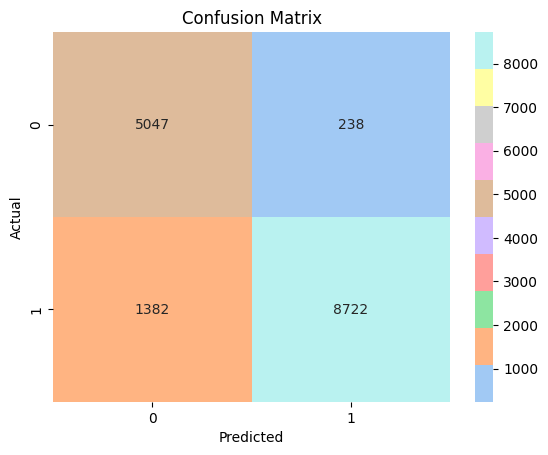

In [46]:
#### creating array of the actual and predicted classifications
actual = no_test_df['classification'].to_numpy()
predicted = no_test_df['predicted'].to_numpy()

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual, predicted)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=sns.color_palette("pastel"))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [47]:
#### calculating accuracy, precision, recall
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")


Accuracy = 0.8947300019494444
Precision = 0.9734375
Recall = 0.8632224861441014
